## Rcognita installation

In [1]:
!pip install rcognita

You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


## Preset: a 3-wheel robot (kinematic model a. k. a. non-holonomic integrator).

### Define name of the notebook

In [2]:
notebook_name = "main_3wrobot_NI.ipynb"

In [3]:
import os, sys
__file__ = os.path.join(os.getcwd(),notebook_name)
PARENT_DIR = os.path.abspath(__file__ + '/../..')
sys.path.insert(0, PARENT_DIR)

import rcognita

if os.path.abspath(rcognita.__file__ + "/../..") == PARENT_DIR:
    info = f"this script is being run using " \
           f"rcognita ({rcognita.__version__}) " \
           f"located in cloned repository at '{PARENT_DIR}'. " \
           f"If you are willing to use your locally installed rcognita, " \
           f"run this script ('{os.path.basename(__file__)}') outside " \
           f"'rcognita/presets'."
else:
    info = f"this script is being run using " \
           f"locally installed rcognita ({rcognita.__version__}). " \
           f"Make sure the versions match."
print("INFO:", info)

import pathlib
    
import warnings
import csv
from datetime import datetime
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np

from rcognita import simulator
from rcognita import systems
from rcognita import controllers
from rcognita import loggers
from rcognita import visuals
from rcognita import estimators
from rcognita.utilities import on_key_press
from argparser_3wrobot_NI import parser
import importlib
import json
import rcognita.models as models

from rcognita.utilities import push_vec

import torch
import torch.optim as optim
import torch.nn as nn

%matplotlib notebook
%load_ext autoreload
%autoreload 2

INFO: this script is being run using rcognita (v0.1.2) located in cloned repository at '/Users/elijah/Documents/edu-2022-safeAI/assignments/asgn-1/rcognita'. If you are willing to use your locally installed rcognita, run this script ('main_3wrobot_NI.ipynb') outside 'rcognita/presets'.


/Users/elijah/Documents/edu-2022-safeAI/assignments/asgn-1/rcognita/rcognita/controllers.py:33: UserWarning: 
Importing sippy failed. You may still use rcognita, but without model identification capability. 
Read on how to install sippy at https://github.com/AIDynamicAction/rcognita

  import sippy


### Configuration and arguments

In [4]:
dim_state = 3
dim_input = 2
dim_output = dim_state
dim_disturb = 0

dim_R1 = dim_output + dim_input
dim_R2 = dim_R1

args = parser.parse_args(["--is_visualization", "True"])

if not isinstance(args.state_init[0], int):
    for k in range(len(args.state_init)):
        args.state_init[k] = eval( args.state_init[k].replace('pi', str(np.pi)) )

args.state_init = np.array(args.state_init)
args.action_manual = np.array(args.action_manual)

pred_step_size = args.dt * args.pred_step_size_multiplier
model_est_period = args.dt * args.model_est_period_multiplier
critic_period = args.dt * args.critic_period_multiplier

R1 = np.diag(np.array(args.R1_diag))
R2 = np.diag(np.array(args.R2_diag))

assert args.t1 > args.dt > 0.0
assert args.state_init.size == dim_state

globals().update(vars(args))

In [5]:
is_disturb = 0
is_dyn_ctrl = 0

t0 = 0

action_init = 0 * np.ones(dim_input)

# Solver
atol = 1e-5
rtol = 1e-3

# xy-plane
xMin = -10
xMax = 10
yMin = -10
yMax = 10

# Model estimator stores models in a stack and recall the best of model_est_checks
model_est_checks = 0

# Control constraints
v_min = -25
v_max = 25
omega_min = -5
omega_max = 5
ctrl_bnds=np.array([[v_min, v_max], [omega_min, omega_max]])

In [6]:
my_sys = systems.Sys3WRobotNI(sys_type="diff_eqn",
                                     dim_state=dim_state,
                                     dim_input=dim_input,
                                     dim_output=dim_output,
                                     dim_disturb=dim_disturb,
                                     pars=[],
                                     ctrl_bnds=ctrl_bnds,
                                     is_dyn_ctrl=is_dyn_ctrl,
                                     is_disturb=is_disturb,
                                     pars_disturb=[])

observation_init = my_sys.out(state_init)

xCoord0 = state_init[0]
yCoord0 = state_init[1]
alpha0 = state_init[2]
alpha_deg_0 = alpha0/2/np.pi

In [7]:
my_ctrl_nominal = controllers.CtrlNominal3WRobotNI(ctrl_gain=0.5, ctrl_bnds=ctrl_bnds, t0=t0, sampling_time=dt)

# Predictive optimal controller
my_ctrl_opt_pred = controllers.CtrlOptPred(dim_input,
                                           dim_output,
                                           ctrl_mode,
                                           ctrl_bnds = ctrl_bnds,
                                           action_init = [],
                                           t0 = t0,
                                           sampling_time = dt,
                                           Nactor = Nactor,
                                           pred_step_size = pred_step_size,
                                           sys_rhs = my_sys._state_dyn,
                                           sys_out = my_sys.out,
                                           state_sys = state_init,
                                           prob_noise_pow = prob_noise_pow,
                                           is_est_model = is_est_model,
                                           model_est_stage = model_est_stage,
                                           model_est_period = model_est_period,
                                           buffer_size = buffer_size,
                                           model_order = model_order,
                                           model_est_checks = model_est_checks,
                                           gamma = gamma,
                                           Ncritic = Ncritic,
                                           critic_period = critic_period,
                                           critic_struct = critic_struct,
                                           stage_obj_struct = stage_obj_struct,
                                           stage_obj_pars = [R1],
                                           observation_target = [])


In [8]:
my_ctrl_RL_stab = controllers.CtrlRLStab(dim_input,
                                         dim_output,
                                         ctrl_mode,
                                         ctrl_bnds = ctrl_bnds,
                                         action_init = action_init,
                                         t0 = t0,
                                         sampling_time = dt,
                                         Nactor = Nactor,
                                         pred_step_size = pred_step_size,
                                         sys_rhs = my_sys._state_dyn,
                                         sys_out = my_sys.out,
                                         state_sys = state_init,
                                         prob_noise_pow = prob_noise_pow,
                                         is_est_model = is_est_model,
                                         model_est_stage = model_est_stage,
                                         model_est_period = model_est_period,
                                         buffer_size = buffer_size,
                                         model_order = model_order,
                                         model_est_checks = model_est_checks,
                                         gamma = gamma,
                                         Ncritic = Ncritic,
                                         critic_period = critic_period,
                                         critic_struct = critic_struct,
                                         actor_struct = actor_struct,
                                         stage_obj_struct = stage_obj_struct,
                                         stage_obj_pars = [R1],
                                         observation_target = [],
                                         safe_ctrl = my_ctrl_nominal,
                                         safe_decay_rate = 1e-4)

if ctrl_mode == 'JACS':
    my_ctrl_benchm = my_ctrl_RL_stab
else:
    my_ctrl_benchm = my_ctrl_opt_pred

In [9]:
my_simulator = simulator.Simulator(sys_type = "diff_eqn",
                                   closed_loop_rhs = my_sys.closed_loop_rhs,
                                   sys_out = my_sys.out,
                                   state_init = state_init,
                                   disturb_init = [],
                                   action_init = action_init,
                                   t0 = t0,
                                   t1 = t1,
                                   dt = dt,
                                   max_step = dt/2,
                                   first_step = 1e-6,
                                   atol = atol,
                                   rtol = rtol,
                                   is_disturb = is_disturb,
                                   is_dyn_ctrl = is_dyn_ctrl)

In [10]:
if os.path.basename( os.path.normpath( os.path.abspath(os.getcwd()) ) ) == 'presets':
    data_folder = '../simdata'
else:
    data_folder = 'simdata'

pathlib.Path(data_folder).mkdir(parents=True, exist_ok=True) 

date = datetime.now().strftime("%Y-%m-%d")
time = datetime.now().strftime("%Hh%Mm%Ss")
datafiles = [None] * Nruns

for k in range(0, Nruns):
    datafiles[k] = data_folder + '/' + my_sys.name + '__' + ctrl_mode + '__' + date + '__' + time + '__run{run:02d}.csv'.format(run=k+1)
    
    if is_log_data:
        print('Logging data to:    ' + datafiles[k])
            
        with open(datafiles[k], 'w', newline='') as outfile:
            writer = csv.writer(outfile)
            writer.writerow(['System', my_sys.name ] )
            writer.writerow(['Controller', ctrl_mode ] )
            writer.writerow(['dt', str(dt) ] )
            writer.writerow(['state_init', str(state_init) ] )
            writer.writerow(['is_est_model', str(is_est_model) ] )
            writer.writerow(['model_est_stage', str(model_est_stage) ] )
            writer.writerow(['model_est_period_multiplier', str(model_est_period_multiplier) ] )
            writer.writerow(['model_order', str(model_order) ] )
            writer.writerow(['prob_noise_pow', str(prob_noise_pow) ] )
            writer.writerow(['Nactor', str(Nactor) ] )
            writer.writerow(['pred_step_size_multiplier', str(pred_step_size_multiplier) ] )
            writer.writerow(['buffer_size', str(buffer_size) ] )
            writer.writerow(['stage_obj_struct', str(stage_obj_struct) ] )
            writer.writerow(['R1_diag', str(R1_diag) ] )
            writer.writerow(['R2_diag', str(R2_diag) ] )
            writer.writerow(['Ncritic', str(Ncritic) ] )
            writer.writerow(['gamma', str(gamma) ] )
            writer.writerow(['critic_period_multiplier', str(critic_period_multiplier) ] )
            writer.writerow(['critic_struct', str(critic_struct) ] )
            writer.writerow(['actor_struct', str(actor_struct) ] )   
            writer.writerow(['t [s]', 'x [m]', 'y [m]', 'alpha [rad]', 'stage_obj', 'accum_obj', 'v [m/s]', 'omega [rad/s]'] )


In [11]:
class Estimator_RNN:
    """
    Class of model estimators based on recurrent neural networks
    """

    def __init__(self, dim_observation, dim_action, dim_hidden, buffer_size, model = None, Nbackprops = 1):
        self.buffer_size = buffer_size

        self.dim_observation = dim_observation
        self.dim_action      = dim_action
        self.dim_hidden      = dim_hidden

        if (model is None):
            self.model = models.ModelRNN(None, self.dim_observation, self.dim_action, self.dim_hidden)

        else:
            self.model = model

        self.criterion = nn.MSELoss()
        self.optimizer = optim.SGD(self.model.parameters(), lr=0.001, momentum=0.9)

        self.observation_buffer = np.zeros((self.buffer_size, self.dim_observation), dtype = np.float64)
        self.action_buffer      = np.zeros((self.buffer_size, self.dim_action), dtype = np.float64)

        self.Nbackprops = Nbackprops

    def receive_sys_IO(self, observation, action):
        # push observation, action to buffers -- see functionality in controllers.py, line 1463

        self.observation_buffer = push_vec(self.observation_buffer, observation)
        self.action_buffer      = push_vec(self.action_buffer, action)

    def update_params(self):
        """
        Update neural network weights
        """

        # Torch backprop (Nbackprops times, say) on loss = model accuracy over buffers

        self.loss.backward()

    def output_loss(self):
        """
        Return current loss
        """

        self.loss = 0

        for i in range(self.buffer_size - 1):
            #y_pred = self.model.model_out(np.concatenate((self.observation_buffer[i, :], self.action_buffer[i, :])))
            y_pred = self.model.model_out(self.observation_buffer[i, :], self.action_buffer[i, :])

            #loss += np.linalg.norm((y_pred.detach().numpy() - self.observation_buffer[i + 1, :]))
            self.loss += self.criterion(y_pred, torch.tensor(self.observation_buffer[i + 1, :]))

        return self.loss.detach().numpy()

In [12]:
if is_print_sim_step:
    warnings.filterwarnings('ignore')
    
my_logger = loggers.Logger3WRobotNI()

my_estimator = Estimator_RNN(dim_action = dim_input, dim_observation = dim_output,
                             dim_hidden = 10, buffer_size = 10)

In [13]:
#TODO:
# rename Animator3WRobotNI_customized into Animator3WRobotNI_estimator
# in private and public repos
# 
# 
# 

class Animator3WRobotNI_customized(visuals.Animator3WRobotNI):
    def __init__(self, objects=[], pars=[]):
        super().__init__(objects, pars)
        
        self.action = action_init
    
    def no_playback(self):
        self.simulator.sim_step()

        t, state, observation, state_full = self.simulator.get_sim_step_data()

        #############################################
        # ESTIMATOR UNDER DEVELOPMENT
        #############################################

        my_estimator.receive_sys_IO(observation, self.action)

        estimator_loss = my_estimator.output_loss()
        
        my_estimator.update_params()
        
        #############################################
        
        action = self.ctrl_selector(t, observation, self.action_manual, self.ctrl_nominal,
                                    self.ctrl_benchmarking, self.ctrl_mode)

        self.action = action
        
        self.sys.receive_action(action)
        self.ctrl_benchmarking.receive_sys_state(self.sys._state)
        self.ctrl_benchmarking.upd_accum_obj(observation, action)

        stage_obj = self.ctrl_benchmarking.stage_obj(observation, action)
        accum_obj = self.ctrl_benchmarking.accum_obj_val

        return t, state, observation, state_full, action, stage_obj, accum_obj, estimator_loss

## Main loop

<IPython.core.display.Javascript object>


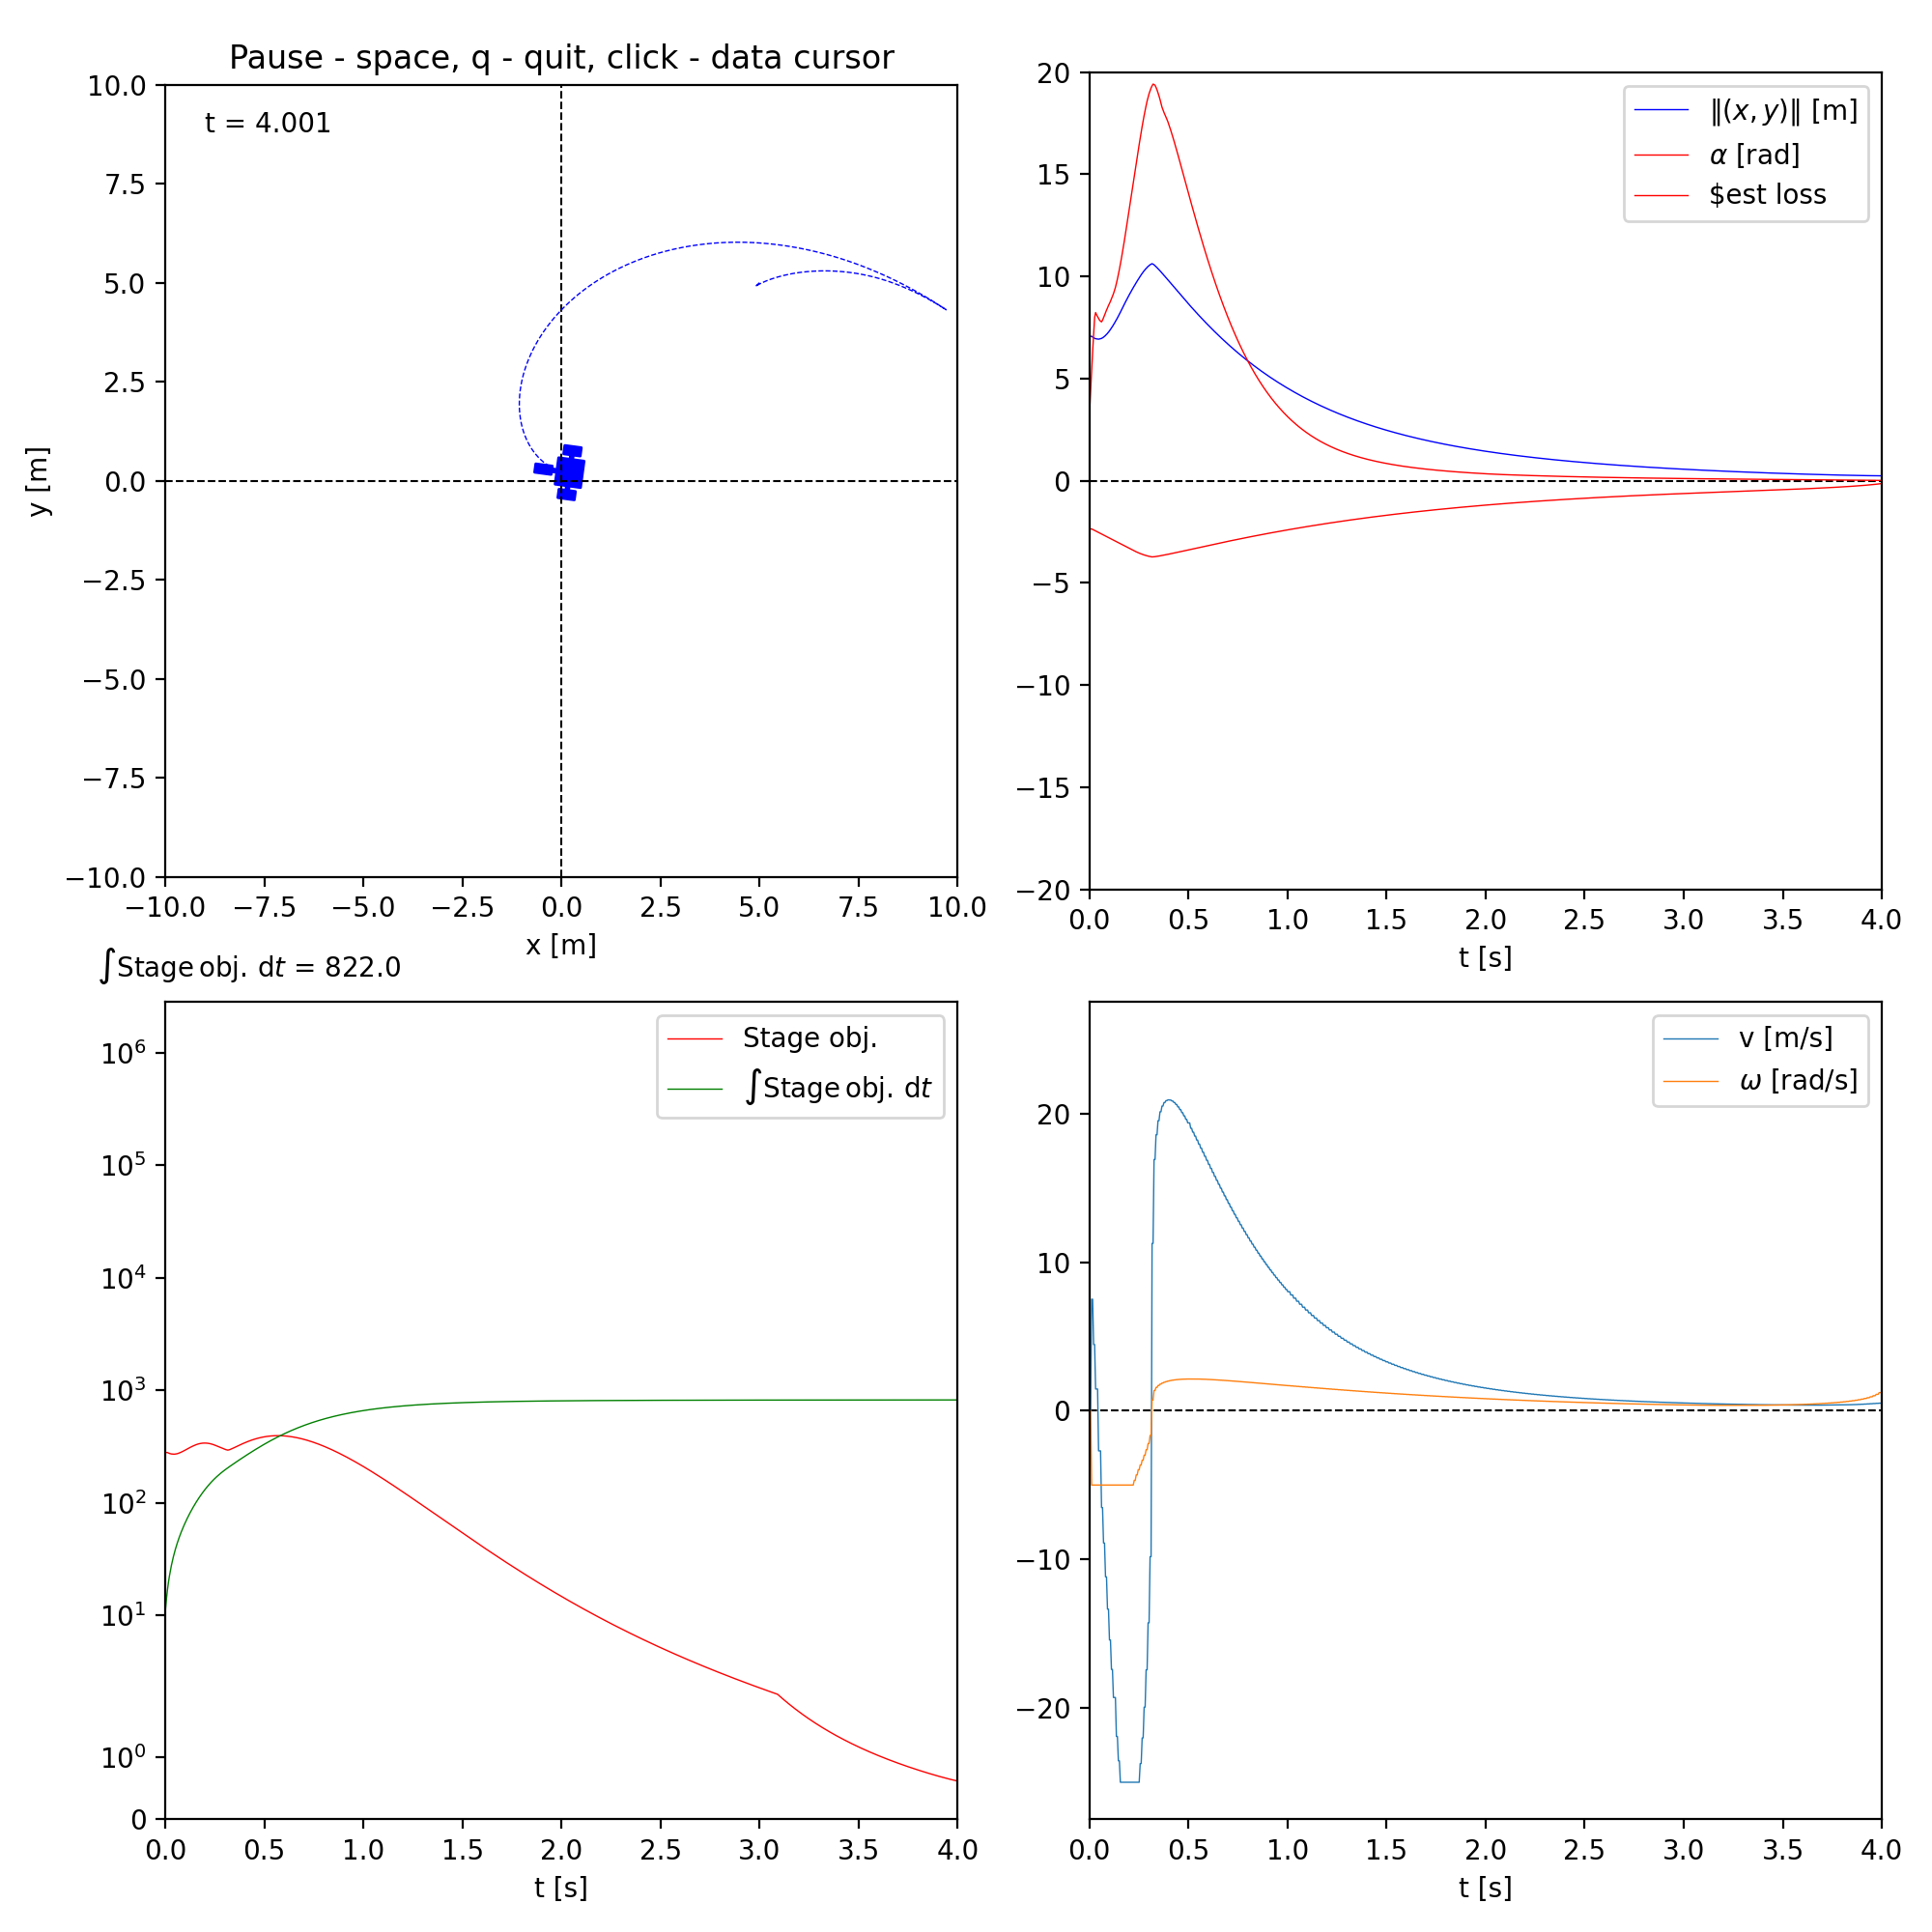

In [14]:
t1 = 4

if is_visualization:
    state_full_init = my_simulator.state_full
    
    my_animator = Animator3WRobotNI_customized(objects=(my_simulator,
                                                     my_sys,
                                                     my_ctrl_nominal,
                                                     my_ctrl_benchm,
                                                     datafiles,
                                                     controllers.ctrl_selector,
                                                     my_logger),
                                            pars=(state_init,
                                                  action_init,
                                                  t0,
                                                  t1,
                                                  state_full_init,
                                                  xMin,
                                                  xMax,
                                                  yMin,
                                                  yMax,
                                                  ctrl_mode,
                                                  action_manual,
                                                  v_min,
                                                  omega_min,
                                                  v_max,
                                                  omega_max,
                                                  Nruns,
                                                    is_print_sim_step, is_log_data, 0, []))

    anm = animation.FuncAnimation(my_animator.fig_sim,
                                  my_animator.animate,
                                  init_func=my_animator.init_anim,
                                  blit=False, interval=dt/1e6, repeat=False)
    
    my_animator.get_anm(anm)
    
    cId = my_animator.fig_sim.canvas.mpl_connect('key_press_event', lambda event: on_key_press(event, anm))
    
    anm.running = True
    
    my_animator.fig_sim.tight_layout()
    
    plt.show()
    
else:   
    run_curr = 1
    datafile = datafiles[0]
    
    while True:
        
        my_simulator.sim_step()
        
        t, state, observation, state_full = my_simulator.get_sim_step_data()
        
        action = controllers.ctrl_selector(t, observation, action_manual, my_ctrl_nominal, my_ctrl_benchm, ctrl_mode)
        
        my_sys.receive_action(action)
        my_ctrl_benchm.receive_sys_state(my_sys._state)
        my_ctrl_benchm.upd_accum_obj(observation, action)
        
        xCoord = state_full[0]
        yCoord = state_full[1]
        alpha = state_full[2]
        
        stage_obj = my_ctrl_benchm.stage_obj(observation, action)
        accum_obj = my_ctrl_benchm.accum_obj_val
        print(f"is_sim_step equals {is_print_sim_step}")
        if is_print_sim_step:
            my_logger.print_sim_step(t, xCoord, yCoord, alpha, stage_obj, accum_obj, action)
            
        if is_log_data:
            my_logger.log_data_row(datafile, t, xCoord, yCoord, alpha, stage_obj, accum_obj, action)
        
        if t >= t1:  
            if is_print_sim_step:
                print('.....................................Run {run:2d} done.....................................'.format(run = run_curr))
                
            run_curr += 1
            
            if run_curr > Nruns:
                break
                
            if is_log_data:
                datafile = datafiles[run_curr-1]
            
            # Reset simulator
            my_simulator.status = 'running'
            my_simulator.t = t0
            my_simulator.observation = state_full_init
            
            if ctrl_mode != 'nominal':
                my_ctrl_benchm.reset(t0)
            else:
                my_ctrl_nominal.reset(t0)
            
            accum_obj = 0  


In [15]:
is_visualization

True